 <span style="color:MediumAquamarine"><font size="13"> *BUSINESS PROBLEM: explore a hotel booking dataset and predict cancellation* </font></span>

# STAGE 1: preprecessing and EDA

## Load Data and Explore

In [1]:
import pandas as pd
df_hotel = pd.read_csv('~/Downloads/hotel_bookings.csv')
df_hotel.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [2]:
# Check Columns
df_hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

CONSIDERATIONS: Our target feature to predict is 'is canceled'. We should treat and select all other features. First we need to explore it.

In [3]:
# Check missing values
import numpy as np
import pandas as pd

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df_hotel)

Your selected dataframe has 32 columns and 119390 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
company,0,112593,94.3,112593,94.3,float64
agent,0,16340,13.7,16340,13.7,float64
country,0,488,0.4,488,0.4,object
children,110796,4,0.0,110800,92.8,float64


CONSIDERATIONS: country and children doesn't have many missing values ('0' in children means it's not a missing value); 
our problem is with company and agent, we should explore and treat it.

In [4]:
# count of id companies when made reservation
len(df_hotel['company'].unique())

353

In [5]:
# Aggregate and check distribution from the variable
df_company_agg = df_hotel.groupby('company')['company'].count().sort_values(ascending = False)
df_company_agg.head(5)

company
40.0     927
223.0    784
67.0     267
45.0     250
153.0    215
Name: company, dtype: int64

CONSIDERATIONS: we've too many missing values for company; probably those missing values mean that the reservation weren't scheduled by any company; it would be better to create a boolean feature to detect if it's a company reservation or not.

In [6]:
import numpy as np
# Create a new boolean feature considering if it's a company reservation or not
df_hotel['is_company'] = np.where(df_hotel['company'].isna(), False, True)
# Drop company column as we don't need it anymore and we can get rid from nan values
df_hotel.drop(['company'], axis=1)
# check the number of reservations by companies
df_hotel['is_company'].sum()

6797

In [7]:
# Drop old column to clean our data (it will help plotting correlation matrix and fitting the model)
df_hotel = df_hotel.drop(['company'], axis=1)

CONSIDERATIONS: it's rare for companies to book!

In [8]:
# Create a new boolean feature considering if it's a reservation made by an agent or not
df_hotel['is_agent'] = np.where(df_hotel['agent'].isna(), False, True)
df_hotel['is_agent'].sum()

103050

CONSIDERATIONS: booking by agents are much more common than by companies; but probably direct reservations are also important.

In [9]:
# Aggegate and check which market segments cancels more by type of hotel
df_hotel.groupby(['market_segment', 'is_canceled'])['hotel'].count()

market_segment  is_canceled
Aviation        0                185
                1                 52
Complementary   0                646
                1                 97
Corporate       0               4303
                1                992
Direct          0              10672
                1               1934
Groups          0               7714
                1              12097
Offline TA/TO   0              15908
                1               8311
Online TA       0              35738
                1              20739
Undefined       1                  2
Name: hotel, dtype: int64

CONSIDERATIONS: Most cancelations are from ONLINE booking and GROUPS.

In [10]:
# Check types of reservation status by cancelation type
df_hotel.groupby(['reservation_status', 'is_canceled'])['hotel'].count()

reservation_status  is_canceled
Canceled            1              43017
Check-Out           0              75166
No-Show             1               1207
Name: hotel, dtype: int64

## Transform Data

In [11]:
# Correct datetime
df_hotel[['reservation_status_date']] = df_hotel[['reservation_status_date']].astype('datetime64[ns]')

# Correct all categorical (except our target 'is_canceled') features including booleans (we can't use bool type or target variable as categorical to fit the model)
df_hotel[["hotel", "meal", "country", 
      "market_segment", "distribution_channel", 
      "reserved_room_type", "assigned_room_type", 
      "deposit_type", "customer_type", 
      "reservation_status"]] = df_hotel[["hotel", "meal", "country", "market_segment", 
                                       "distribution_channel", "reserved_room_type", "assigned_room_type", 
                                       "deposit_type", "customer_type", 
                                       "reservation_status",]].astype('category')

df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(bool)



# Fill missing values from agent column and transform it to a categorical column
from statistics import mode
df_hotel[["agent"]] = df_hotel[["agent"]].astype(pd.Int32Dtype())
df_hotel_list = df_hotel[["agent"]].values.tolist()
def flatten(t):
    return [item for sublist in t for item in sublist]
flat_hotel = flatten(df_hotel_list)
flat_mode = mode(flat_hotel)
df_hotel[["agent"]] = df_hotel[["agent"]].fillna(9)
df_hotel[["agent"]] = df_hotel[["agent"]].astype('int64')

# Fill na's from float column with the median
df_hotel['children'] = df_hotel['children'].fillna(df_hotel['children'].median()).astype('int64')

# Drop nan's rows from columns with inexpressive nan's count
df_hotel = df_hotel.dropna(subset = ['country', 'children'], axis = 0)

df_hotel.dtypes

hotel                                   category
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                    category
country                                 category
market_segment                          category
distribution_channel                    category
is_repeated_guest                           bool
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                      category
assigned_room_type  

CONSIDERATION 1: We could have explored more our columns to set which could be ordinal encoded (such as months or year) but the time it would consume could be too much and it's not guaranteed it would help us; \
CONSIDERATION 2: We could also have done one hot encoding for our categorical columns, but expand our dataframe and it would be more expensive to train the model or scale it if we would deploy based on big data;\
CONSIDERATION 3: We could have predicted our missing values with a regression model, but in our case it wasn't necessary; \
CONSIDERATION 4: We just need to treat datetimes and we are ready to fit for modelling! Let's create new features!

In [12]:
# Create a new feature which corrects datetime from reservation_status_date
df_hotel[['reservation_status_date_dt']] = df_hotel[['reservation_status_date']].astype('datetime64[ns]')

# Create a new feature which contains the full date of arrival and convert it to datetime
df_hotel['arrivel_date'] = df_hotel['arrival_date_year'].astype(str) + '-' + df_hotel['arrival_date_month'] + '-' + df_hotel['arrival_date_day_of_month'].astype(str)
df_hotel[['arrivel_date_dt']] = df_hotel[['arrivel_date']].astype('datetime64[ns]')

#Check transformation
df_hotel[['arrivel_date','arrivel_date_dt', 'reservation_status_date', 'reservation_status_date_dt']].tail(5)

,arrivel_date,arrivel_date_dt,reservation_status_date,reservation_status_date_dt
119385,2017-August-30,2017-08-30,2017-09-06,2017-09-06
119386,2017-August-31,2017-08-31,2017-09-07,2017-09-07
119387,2017-August-31,2017-08-31,2017-09-07,2017-09-07
119388,2017-August-31,2017-08-31,2017-09-07,2017-09-07
119389,2017-August-29,2017-08-29,2017-09-07,2017-09-07


In [13]:
from datetime import timedelta
# Create a datetime feature which tells how many days before the reservations was cancelled and check if it matches
df_hotel['lead_time_dt'] = df_hotel['lead_time'].apply(lambda x: timedelta(days = x))
df_hotel['booking_date'] = df_hotel['arrivel_date_dt'] - df_hotel['lead_time_dt']
df_hotel[['booking_date', 'arrivel_date', 'lead_time', 'lead_time_dt']].head(5)

,booking_date,arrivel_date,lead_time,lead_time_dt
0,2014-07-24,2015-July-1,342,342 days
1,2013-06-24,2015-July-1,737,737 days
2,2015-06-24,2015-July-1,7,7 days
3,2015-06-18,2015-July-1,13,13 days
4,2015-06-17,2015-July-1,14,14 days


In [14]:
# Drop old columns after check
# df_hotel = df_hotel.drop(['arrivel_date', 'lead_time', 'reservation_status_date'], axis=1)

In [15]:
# Create a new feature to identify HIGH SEASON BY COUNTRY and if the reservation was made in high or low season
df_hotel['n_rows_country'] = df_hotel.groupby(['country'])['country'].transform('count')
# Filter by most relevant countries
df_hotel['grouped_country'] = np.where(df_hotel['n_rows_country'] < 5000, 'other', df_hotel['country'])
table = df_hotel.groupby(['grouped_country', 'arrival_date_year', 'arrival_date_month']).agg(n_canceled = pd.NamedAgg('is_canceled', 'sum'), n_total = pd.NamedAgg('is_canceled', 'count')).reset_index()
table['country_year_total'] = (table.groupby(['grouped_country', 'arrival_date_year'])['n_total'].transform('sum')) / 12
# Set season by trheshold
table['season_index'] = table['n_total'] / table['country_year_total']
table['high_season'] = np.where(table['season_index'] < 1, 0, 1)
table_agg = table.sort_values(['grouped_country', 'arrival_date_year']).groupby(['grouped_country', 'arrival_date_month']).agg(n_high = pd.NamedAgg('high_season', 'sum'), n_total = pd.NamedAgg('high_season', 'count')).reset_index()
table_agg['high_season'] = np.where(table_agg['n_high'] >= table_agg['n_total'], 1, 0)
table_agg = table_agg[['grouped_country', 'arrival_date_month', 'high_season']]
df_hotel['grouped_country'] = df_hotel['grouped_country'].astype('category')
# Merge table created to define high season with original table
df_hotel = df_hotel.merge(table_agg, how = 'left', on = ['grouped_country', 'arrival_date_month'])
df_hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_company,is_agent,reservation_status_date_dt,arrivel_date,arrivel_date_dt,lead_time_dt,booking_date,n_rows_country,grouped_country,high_season
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,False,False,2015-07-01,2015-July-1,2015-07-01,342 days,2014-07-24,48590,PRT,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,False,False,2015-07-01,2015-July-1,2015-07-01,737 days,2013-06-24,48590,PRT,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,False,False,2015-07-02,2015-July-1,2015-07-01,7 days,2015-06-24,12129,GBR,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,False,True,2015-07-02,2015-July-1,2015-07-01,13 days,2015-06-18,12129,GBR,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,False,True,2015-07-03,2015-July-1,2015-07-01,14 days,2015-06-17,12129,GBR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118897,City Hotel,0,23,2017,August,35,30,2,5,2,...,False,True,2017-09-06,2017-August-30,2017-08-30,23 days,2017-08-07,2342,other,1
118898,City Hotel,0,102,2017,August,35,31,2,5,3,...,False,True,2017-09-07,2017-August-31,2017-08-31,102 days,2017-05-21,10415,FRA,1
118899,City Hotel,0,34,2017,August,35,31,2,5,2,...,False,True,2017-09-07,2017-August-31,2017-08-31,34 days,2017-07-28,7287,DEU,1
118900,City Hotel,0,109,2017,August,35,31,2,5,2,...,False,True,2017-09-07,2017-August-31,2017-08-31,109 days,2017-05-14,12129,GBR,0


In [16]:
df_hotel['grouped_country'] = df_hotel['grouped_country'].astype('category')
df_hotel['grouped_country'].dtypes

CategoricalDtype(categories=['DEU', 'ESP', 'FRA', 'GBR', 'PRT', 'other'], ordered=False)

In [17]:
# BONUS: create new boolean feature which tells if it's deposit or not since it looks redundant
df_hotel['is_deposit'] = np.where(df_hotel['deposit_type'] == 'No Deposit', 0, 1)
df_hotel['deposit_type'].unique()
df_hotel['deposit_type'].value_counts()

No Deposit    104167
Non Refund     14573
Refundable       162
Name: deposit_type, dtype: int64

In [18]:
# drop old column to help correlation plot and fitting the model
df_hotel = df_hotel.drop(['is_deposit', 'n_rows_country'], axis=1)

dtype('int64')

## Plot, explore, transform and interpret

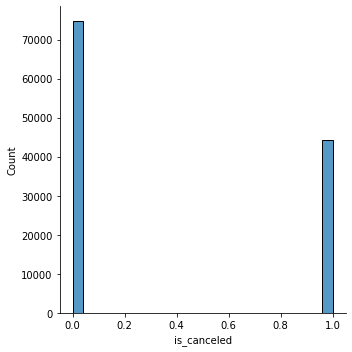

In [46]:
import seaborn as sns
sns.displot(df_hotel, x="is_canceled")

Imbalanced distribution of our target variable. \
We could have even better models if we would have a more data-centric approach and do more feature engineering.

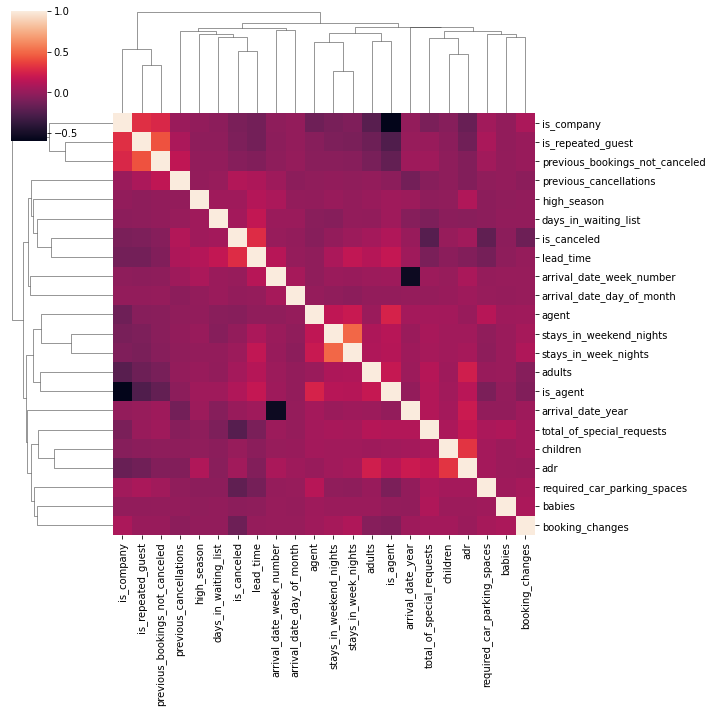

In [19]:
sns.clustermap(df_hotel.corr())

Correlation and dependencies between our features

<AxesSubplot:xlabel='lead_time'>

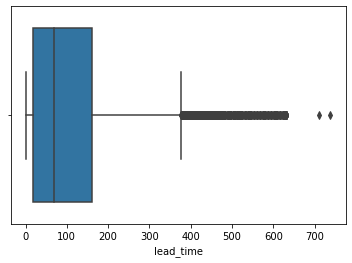

In [20]:
import seaborn as sns
sns.boxplot(x = df_hotel['lead_time'] + 1)

CONSIDERATION 1:boxplotting we can see that most bookings (our interquartile interval) is somewhere in between 1 and 180 days; above 400 are our outliers; \
CONSIDERATION 2: boxplotting we can see that most bookings (our interquartile interval) is somewhere in between 1 and 180 days; above 400 are our outliers; \
CONSIDERATION 3: we can see that most reservations are somewhere in between 80 and 180 days before; \
CONSIDERATION 4: we can see that we still have a considerable ammount of bookings somewehere in between 1 and 10;

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

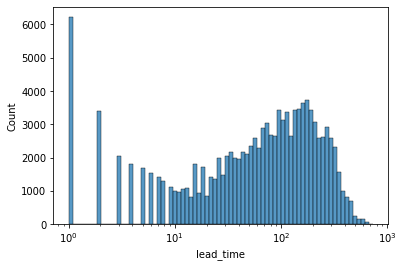

In [21]:
df_hotel['log_lead_time'] = np.log(df_hotel['lead_time'] + 1)
sns.histplot(df_hotel['lead_time'] + 1, log_scale = True)

CONSIDERATION 1: On our histogram we've observed the same as before, a there's a considerable ammount of bookings betwen day 1 and 10; \
CONSIDERATION 2: On our histogram we've observed an odd behaviour ('non-linearity'), a lot of bookings are on day 1; \
CONSIDERATION 3: That means we've two populations and distributions, which we can use to create a new feature: who books at the last minute and who schedule;

In [22]:
# Creating new feature: reservation_type
df_hotel['reservation_type'] = np.where((df_hotel['lead_time'] + 1) < 10, 'last_minute', 'scheduled')
df_hotel.groupby(['reservation_type', 'is_canceled'])['reservation_type'].count()

reservation_type  is_canceled
last_minute       0              18450
                  1               2102
scheduled         0              56295
                  1              42055
Name: reservation_type, dtype: int64

In [23]:
enc_minute = {'last_minute': True, 'scheduled': False}
df_hotel['is_last_minute'] = df_hotel['reservation_type'].map(enc_minute).astype(bool)

In [24]:
df_hotel.dtypes

hotel                                    category
is_canceled                                 int64
lead_time                                   int64
arrival_date_year                           int64
arrival_date_month                         object
arrival_date_week_number                    int64
arrival_date_day_of_month                   int64
stays_in_weekend_nights                     int64
stays_in_week_nights                        int64
adults                                      int64
children                                    int64
babies                                      int64
meal                                     category
country                                  category
market_segment                           category
distribution_channel                     category
is_repeated_guest                            bool
previous_cancellations                      int64
previous_bookings_not_canceled              int64
reserved_room_type                       category


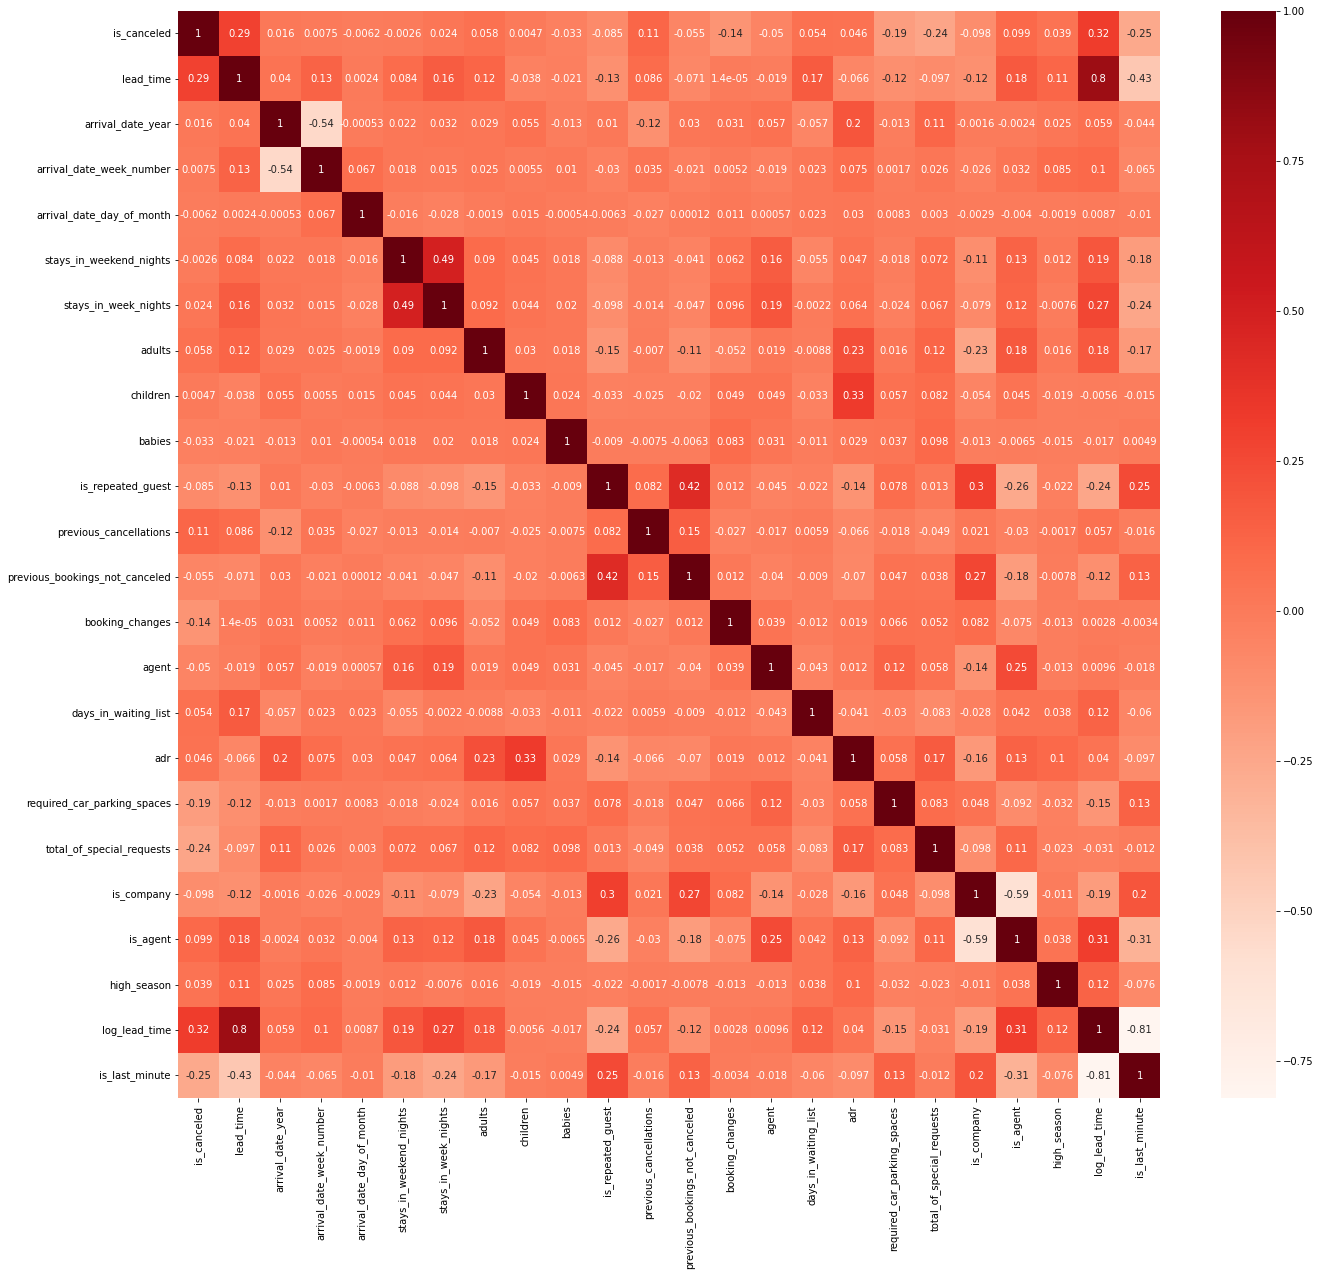

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(22,20))
cor = df_hotel.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

LIST OF RELEVANT CORRELATIONS TO A BUSINESS SPECIALIST INTERPRET: \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) Is canceled with lead time, special request, parking spaces and previous cancellations; some with booking changes; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) Lead time with agent, days in waiting list, high season, adults and stays in week nights; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3) Arrival date year with average daily rate; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4) Adults and number of children with average daily rate; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5) Is repeated guest with previous booking not canceled, is company, average daily rate; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6) Previous booking not canceled with is company; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 7) Average daily rate with number of children, adults, special requests; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 8) Is company with previous booking not cancelled, is repeated guest, adult; \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 9) Is Last minute booking is related to stays in week nights;

# STAGE 2: Comparing two models

## Linear model: logistic regression

Optimization terminated successfully.
         Current function value: 0.602606
         Iterations 6


<AxesSubplot:xlabel='lead_time', ylabel='pred_baseline'>

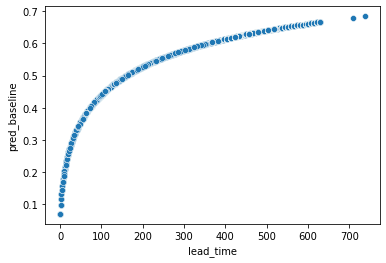

In [26]:
import statsmodels.formula.api as fsm
model = fsm.logit(formula = 'is_canceled ~ log_lead_time' , data = df_hotel)
fit = model.fit()
fit.summary()

df_hotel['pred_baseline'] = fit.predict()
sns.scatterplot(data = df_hotel, x = 'lead_time', y = 'pred_baseline')

Optimization terminated successfully.
         Current function value: 0.600648
         Iterations 6


<AxesSubplot:xlabel='log_lead_time', ylabel='pred_m1'>

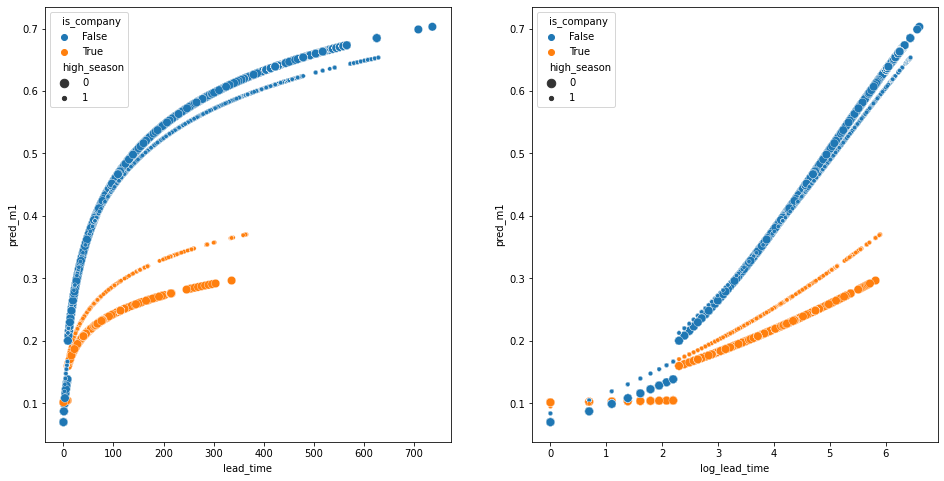

In [27]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as fsm
model = fsm.logit(formula = 'is_canceled ~ log_lead_time : reservation_type * is_company * high_season', data = df_hotel)
fit = model.fit()
fit.summary()
df_hotel['pred_m1'] = fit.predict()

fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.scatterplot(data = df_hotel, x = 'lead_time', y = 'pred_m1', hue = 'is_company', size = 'high_season', ax = ax[0])
sns.scatterplot(data = df_hotel, x = 'log_lead_time', y = 'pred_m1', hue = 'is_company', size = 'high_season', ax = ax[1])

CONSIDERATION 1: We can see our break from two populations (last minute and scheduled) between day 0 and 10; \
CONSIDERATION 2: We can assume that, when it is company, we've MUCH fewer cancellations; \
CONSIDERATION 4: During high season, companies cancel more; \
CONSIDERATION 5: During high season, cancellations done by non-companies slightly decrease; \
CONSIDERATION 6: The gap between high season and low season cancellations get bigger as higher is the lead time; \
CONSIDERATION 7: This gap is stronger when 'is company';

Optimization terminated successfully.
         Current function value: 0.601806
         Iterations 7


<AxesSubplot:xlabel='log_lead_time', ylabel='pred_cancel'>

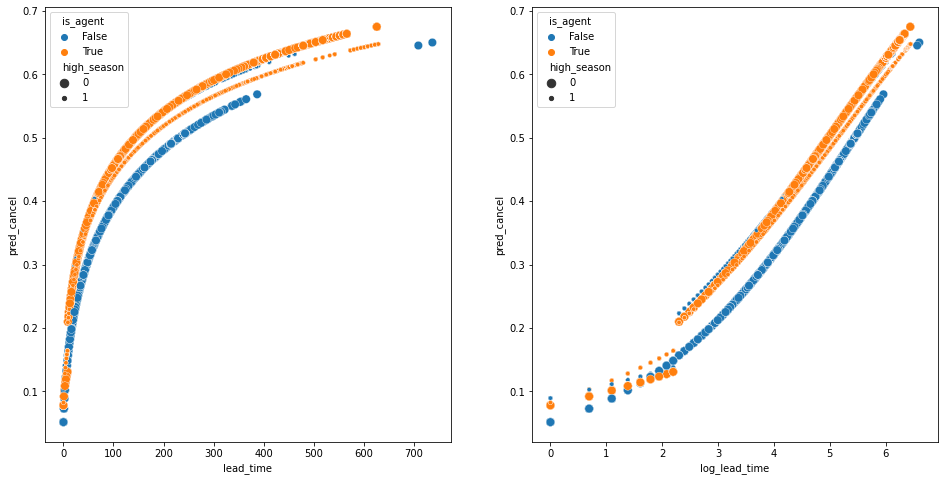

In [28]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as fsm
model = fsm.logit(formula = 'is_canceled ~ log_lead_time : reservation_type * is_agent * high_season', data = df_hotel)
fit = model.fit()
fit.summary()
df_hotel['pred_cancel'] = fit.predict()

fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.scatterplot(data = df_hotel, x = 'lead_time', y = 'pred_cancel', hue = 'is_agent', size = 'high_season', ax = ax[0])
sns.scatterplot(data = df_hotel, x = 'log_lead_time', y = 'pred_cancel', hue = 'is_agent', size = 'high_season', ax = ax[1])

CONSIDERATION 1: After 10 days, when the book is done by an agent, it's more probable to cancel than when it's not booked by an agent.

We can plot a ROC curve to check the performance of a classification model at all classification thresholds, \
considering the trade-off between sensitivity (True Positive Rate) and specificity (True Negative Rate).

Text(0.5, 1.0, 'Best Threshold: 0.26 w/ F-1: 0.6')

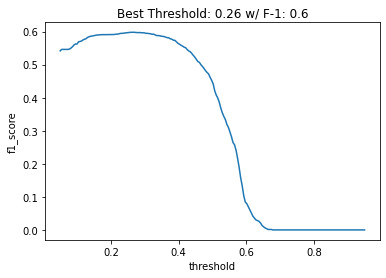

In [30]:
from sklearn.metrics import f1_score

threshold_list = np.linspace(0.05, 0.95, 200)

f1_list = []
for threshold in threshold_list:
    pred_label = np.where(df_hotel['pred_cancel'] < threshold, 0, 1)
    f1 = f1_score(df_hotel['is_canceled'], pred_label)
    f1_list.append(f1)
    
df_f1 = pd.DataFrame({'threshold':threshold_list, 'f1_score': f1_list})
df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]
bt = df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]['threshold'].values[0]
f1 = df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]['f1_score'].values[0]
title = "Best Threshold: " + str(round(bt, 2)) + " w/ F-1: " + str(round(f1, 2))
sns.lineplot(data=df_f1, x='threshold', y='f1_score').set_title(title)

F-1 score finds the best spot between Precision and Recall and it's reasonable to use with binary classification or with multiclass balanced data. \
Most of the times our business problem determines if we should privilege Precision or Recall, but F-1 score is a good generalization to compare the performance of the models. \
We can check and set the best threshold for our model based on the score. 

Text(0.5, 1.0, 'Best Threshold: 0.39 w/ Kappa: 0.24')

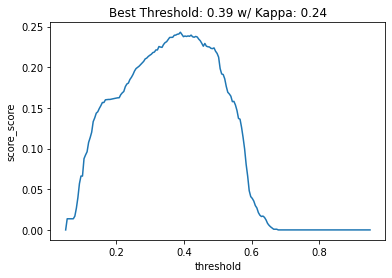

In [31]:
from sklearn.metrics import cohen_kappa_score, precision_score, roc_curve
from sklearn.metrics import matthews_corrcoef, mean_squared_error, log_loss
from sklearn.metrics import f1_score, recall_score, roc_auc_score

threshold_list = np.linspace(0.05, 0.95, 200)

score_list = []
for threshold in threshold_list:
    pred_label = np.where(df_hotel['pred_cancel'] < threshold, 0, 1)
    score = cohen_kappa_score(df_hotel['is_canceled'], pred_label)
    score_list.append(score)

df_score = pd.DataFrame({'threshold':threshold_list, 'score_score': score_list})
df_score[df_score['score_score'] == max(df_score['score_score'])]
bt = df_score[df_score['score_score'] == max(df_score['score_score'])]['threshold'].values[0]
score = df_score[df_score['score_score'] == max(df_score['score_score'])]['score_score'].values[0]
title = "Best Threshold: " + str(round(bt, 2)) + " w/ Kappa: " + str(round(score, 2))
sns.lineplot(data=df_score, x='threshold', y='score_score').set_title(title)

Cohen's Kappa score is a good measure for a classification model since it considers imbalanced data.

<AxesSubplot:>

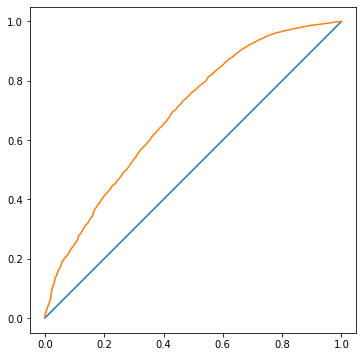

In [29]:
from sklearn.metrics import roc_curve
#Plot ROC_Curve
fpr, tpr, thresholds = roc_curve(df_hotel['is_canceled'], df_hotel['pred_cancel'])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, aspect=1)

sns.lineplot(x = fpr, y = fpr, ax = ax)
sns.lineplot(x = fpr, y = tpr, ax = ax)

An ROC curve shows the performance of one classification model at all classification thresholds. \
It can be used to evaluate the strength of a model. ROC Curves can also be used to compare two models and we've this mind.

### <font size="6"> CONCLUSIONS </font></span>

**We did a hard work to get here. We didn't achieve a reasonable score (0.6) for today parameters, though. But not all is about score.**

* **Advantages**
    * Logistic regression is a simple linear model which is easy and fast to set;
    * It's not computationally expensive, you can run on ordinary hardware;
    * It's highly scalabe;
    * It's not a complex model, no black box, it's highly explainable and interpretable; you can even use it to explore more your data;
    * Excelent to plot, visualize and get insights that wouldn't be possible on complex models;
    * Excelent for risk analysis such as bookings, so we could infer the rate of daily room rate considering risk of cancellation;

* **Disadvantage**
    * It's more handmade, demands more time, work and analytical capabilities from the data scientist who works as a craftsman;
    * It's sensible to outliers and you should be minimalist, to choose less and more important features and treat outliers without loosing data;
    * More dependant of a good feature engineering to get a better score;
    * You can also stratify you modelling and build regressions on top of regressions, but most of the times it's not worth the hard work;
    * You will never get a good result as state-of-art ensemble of hierarchical models and neural networks;

## Ensemble of hierarchical models: XGBoost

### Feature Selection: GridSearchCV

In [32]:
%%time
import numpy as np
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime

# Automate best parameters search for XGBoost using GridSearch
folds = 3
param_comb = 20

# Choose parameters to compare
param_grid = {
     "max_depth": [6, 10, 20, 30],
     "min_child_weight": [1, 3, 10],
     "gamma"            : [0.2 , 0.7, 1, 2],
     "alpha"            : [1],
     "learning_rate":    [0.10, 1, 3],
     "missing":          [np.nan],                      
     "num_parallel_tree": [1, 2],                 
#     "use_rmm": True,                      
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
     "scale_pos_weight": [1, 3], 
     "reg_lambda": [1, 5, 10, 50],
#     "gradient_based": True,
     "subsample": [0.1, 0.5],                    
     }

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# Halving Grid Search CV implementation
xgb_cl = xgb.XGBClassifier(n_estimators=1000,
                           objective='binary:logistic',
                           silent=True, 
                           nthread=40,
                           tree_method='gpu_hist', 
                           eval_metric='auc')

halving_cv = HalvingGridSearchCV(xgb_cl, 
                                 param_grid, 
                                 scoring="roc_auc", 
                                 #n_jobs=4, 
                                 min_resources="exhaust",
                                 factor=3,
                                 #scoring="neg_log_loss", 
                                 #cv=skf.split(X_train,Y_train),
                                 verbose=1, 
                                 random_state=1001,
                                )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable

# halving_cv.fit(X_train, Y_train)
# # Return set of parameters with the best performance
# halving_cv.best_params_
# # Return the performance metric score
# halving_cv.best_score_

# model.dump_model('dump.raw.txt')

# timer(start_time) # timing ends here for "start_time" variable

CPU times: user 80.7 ms, sys: 12.2 ms, total: 92.9 ms
Wall time: 95.6 ms


/home/ggnicolau/miniconda3/envs/jupyter-1/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<font size="3"> <center><p> **CONSIDERATION: We would like to automate the search for the best parameters, but it takes more time than we had. \
                                             We decided to securely set the parameters on a conservative approach as suggested by the community, after empirical testing.** </p></center></font></span>

### BEST MODEL TO COMPARE: XGboost using all features with binary logistic and avoiding LEAKAGE

In [33]:
%%time
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import cohen_kappa_score, precision_score
from sklearn.metrics import matthews_corrcoef, mean_squared_error, log_loss
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# Define your features and your target to predict (selecting ALL columns WITHOUT LEAKAGE!)
X = df_hotel[['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 
                    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 
                    'babies', 'meal','country', 'market_segment', 'distribution_channel',
                    'is_repeated_guest', 'previous_cancellations',
                    'previous_bookings_not_canceled', 'reserved_room_type',
                    'assigned_room_type', 'booking_changes', 'deposit_type',
                    'days_in_waiting_list', 'customer_type', 'adr',
                    'required_car_parking_spaces', 'total_of_special_requests',
                    'is_company','is_agent']]

Y = df_hotel['is_canceled']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
Y_train = Y_train
Y_test = Y_test

full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns)], remainder='passthrough')

encoder = full_pipeline.fit(X_train)
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

# train the model
model = XGBRegressor(n_estimators= 200,
                     max_depth= 30,                         # Lower ratios avoid over-fitting. Default is 6.
                     objective = 'binary:logistic',         # Default is reg:squarederror. 'multi:softprob' for multiclass and get proba.  
                     #num_class = 2,                        # Use if softprob is set.
                     reg_lambda = 10,                       # Larger ratios avoid over-fitting. Default is 1.
                     gamma = 0.3,                           # Larger values avoid over-fitting. Default is 0. # Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
                     alpha = 1,                             # Larger ratios avoid over-fitting. Default is 0.
                     learning_rate= 0.10,                   # Lower ratios avoid over-fitting. Default is 3.
                     colsample_bytree= 0.7,                 # Lower ratios avoid over-fitting.
                     scale_pos_weight = 1,                  # Default is 1. Control balance of positive and negative weights, for unbalanced classes.
                     subsample = 0.1,                       # Lower ratios avoid over-fitting. Default 1. 0.5 recommended. # 0.1 if using GPU.
                     min_child_weight = 3,                  # Larger ratios avoid over-fitting. Default is 1.
                     missing = np.nan,                      # Deal with missing values
                     num_parallel_tree = 2,                 # Parallel trees constructed during each iteration. Default is 1.
                     importance_type = 'weight',
                     eval_metric = 'auc',
                     #use_label_encoder = True,
                     #enable_categorical = True,
                     verbosity = 1,
                     nthread = -1,                          # Set -1 to use all threads.
                     #use_rmm = True,                       # Use GPU if available
                     tree_method = 'auto', # auto           # 'gpu_hist'. Default is auto: analyze the data and chooses the fastest.
                     #gradient_based = True,                # If True you can set subsample as low as 0.1. Only use with gpu_hist 
                    )

# fit model              
model.fit(X_train_enc, Y_train.values.ravel(),
          # early_stopping_rounds=20
         )

# check best ntree limit
display(model.best_ntree_limit)

# extract the training set predictions
preds_train = model.predict(X_train_enc,
                            ntree_limit=model.best_ntree_limit
                           )
# extract the test set predictions
preds_test = model.predict(X_test_enc,
                           ntree_limit=model.best_ntree_limit
                           )

# save model
output_dir = "models"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# save in JSON format
model.save_model(f'{output_dir}/hotel_xgboost.json')
# save in text format
model.save_model(f'{output_dir}/hotel_xgboost.txt')

print('FINISHED!')

400

/home/ggnicolau/miniconda3/envs/jupyter-1/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


FINISHED!
CPU times: user 4min 11s, sys: 384 ms, total: 4min 12s
Wall time: 34.8 s


Setting our parameters at a conservative approach and with a number of steps of 200 took about 4 minutes. \
We'll use this 'step' pattern to compare other settings. \
If we would put this model in production we probably should expand our model to train for more time considering learning rate and steps.

<font size="3"> <center><p> **Plot & Score** </p></center></font></span>

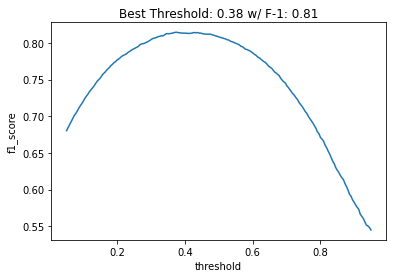

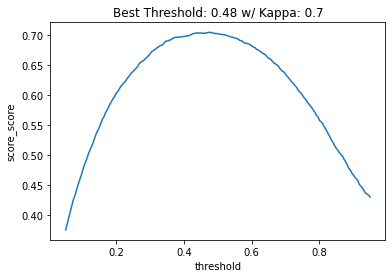

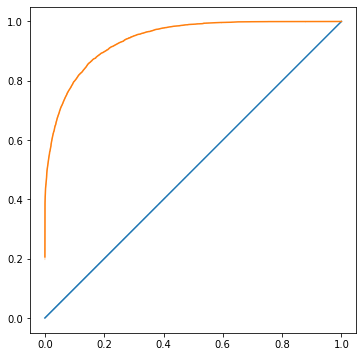

CPU times: user 1min 13s, sys: 572 ms, total: 1min 14s
Wall time: 1min 13s


In [34]:
%%time
# Plot F1-Score and Threshold
from sklearn.metrics import f1_score

threshold_list = np.linspace(0.05, 0.95, 200)

f1_list = []
for threshold in threshold_list:
    pred_label = np.where(preds_test < threshold, 0, 1)
    f1 = f1_score(Y_test, pred_label)
    f1_list.append(f1)

df_f1 = pd.DataFrame({'threshold':threshold_list, 'f1_score': f1_list})
df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]
bt = df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]['threshold'].values[0]
f1 = df_f1[df_f1['f1_score'] == max(df_f1['f1_score'])]['f1_score'].values[0]
title = "Best Threshold: " + str(round(bt, 2)) + " w/ F-1: " + str(round(f1, 2))
sns.lineplot(data=df_f1, x='threshold', y='f1_score').set_title(title)
plt.show()

# Plot Kappa Score and threshold
threshold_list = np.linspace(0.05, 0.95, 200)

score_list = []
for threshold in threshold_list:
    pred_label = np.where(preds_test < threshold, 0, 1)
    score = cohen_kappa_score(Y_test, pred_label)
    score_list.append(score)

df_score = pd.DataFrame({'threshold':threshold_list, 'score_score': score_list})
df_score[df_score['score_score'] == max(df_score['score_score'])]
bt = df_score[df_score['score_score'] == max(df_score['score_score'])]['threshold'].values[0]
score = df_score[df_score['score_score'] == max(df_score['score_score'])]['score_score'].values[0]
title = "Best Threshold: " + str(round(bt, 2)) + " w/ Kappa: " + str(round(score, 2))
sns.lineplot(data=df_score, x='threshold', y='score_score').set_title(title)
plt.show()

from sklearn.metrics import roc_curve

#Plot ROC_Curve
fpr, tpr, thresholds = roc_curve(Y_test, preds_test)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, aspect=1)

sns.lineplot(x = fpr, y = fpr, ax = ax)
sns.lineplot(x = fpr, y = tpr, ax = ax)
plt.show()

***Our ROC curve is MUCH better on all thresholds compared with our logistic regression! We've a nice and even curve which doesn't appear to be overfitting!***

In [35]:
from sklearn.metrics import roc_auc_score

best_preds = np.where(preds_test < bt, 0, 1)

print("Roc_auc = {}".format(roc_auc_score(Y_test, best_preds)))
print("Precision = {}".format(precision_score(Y_test, best_preds)))
print("Recall = {}".format(recall_score(Y_test, best_preds)))
print("F1 = {}".format(f1_score(Y_test, best_preds)))
print("Kappa_score = {}".format(cohen_kappa_score(Y_test, best_preds)))
print("Matthews_corrcoef = {}".format(matthews_corrcoef(Y_test, best_preds)))
print("Mean_squared_error_test = {}".format(mean_squared_error(Y_test, best_preds)))
print("Logloss_test = {}".format(log_loss(Y_test, best_preds)))

Roc_auc = 0.8492998797960843
Precision = 0.8289085545722714
Recall = 0.7955832389580973
F1 = 0.8119040739670615
Kappa_score = 0.7043968112863238
Matthews_corrcoef = 0.704763163688087
Mean_squared_error_test = 0.13687397502207646
Logloss_test = 4.727508371460749


**Now we've a reasonable predictive model**! It could be even improved findind best parameters. \
Using the best threshold for Kappa score improved our overall scores compared with best F-1 score threshold, probably due to imbalanced class.

### XGBoost with manually selected features using Patsy and Softprob

In [36]:
%%time
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import patsy
# Selecting features I manually found interesting analyzing matthew's correlation and using patsy to automatic interact between features.
y, X = patsy.dmatrices('is_canceled ~ hotel + lead_time + arrival_date_year + arrival_date_month + stays_in_weekend_nights + \
                       stays_in_week_nights + adults + children + babies + meal + country + market_segment + distribution_channel + \
                       is_repeated_guest + previous_cancellations + previous_bookings_not_canceled + reserved_room_type + \
                       assigned_room_type + booking_changes + deposit_type + days_in_waiting_list + customer_type + adr + \
                       required_car_parking_spaces + total_of_special_requests + is_company + is_agent', data = df_hotel)



                    
# Display patsy features
#display(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

D_train = xgb.DMatrix(X_train, label=Y_train)#, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=Y_test)#, enable_categorical=True)


param = {
    'eta': 0.10,                      # Lower ratios avoid over-fitting. Default is 3.
    'max_depth': 30,                  # Lower ratios avoid over-fitting. Default is 6.
    "min_child_weight": 3,            # Larger ratios avoid over-fitting. Default is 1.
    "gamma": 0.3,                     # Larger values avoid over-fitting. Default is 0. 
    "colsample_bytree" : 0.7,         # Lower ratios avoid over-fitting. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
    "scale_pos_weight": 1,            # Default is 1. Control balance of positive and negative weights, for unbalanced classes.
    "reg_lambda": 10,                 # Larger ratios avoid over-fitting. Default is 1.
    "alpha": 1,                       # Larger ratios avoid over-fitting. Default is 0.
    'subsample':0.5,                  # Lower ratios avoid over-fitting. Default 1. 0.5 recommended.
    'num_parallel_tree': 2,           # Parallel trees constructed during each iteration. Default is 1.
    'objective': 'multi:softprob',    # Default is reg:squarederror. 'multi:softprob' for multiclass.  
    'num_class': 2,                   # Use if softprob is set.
    'verbosity':1,
    'eval_metric': 'auc',
    'use_rmm':False,                   # Use GPU if available
    'nthread':-1,                      # Set -1 to use all threads.
    'tree_method': 'auto',             # 'gpu_hist'. Default is auto: analyze the data and chooses the fastest.
    'gradient_based': False,           # If True you can set subsample as low as 0.1. Only use with gpu_hist 
} 

steps = 200  # The number of training iterations

model = xgb.train(param, D_train, steps)
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds)))
print("Recall = {}".format(recall_score(Y_test, best_preds)))
print("f1 = {}".format(f1_score(Y_test, best_preds)))
print("kappa_score = {}".format(cohen_kappa_score(Y_test, best_preds)))
print("matthews_corrcoef = {}".format(matthews_corrcoef(Y_test, best_preds)))
#print("mean_squared_error_train = {}".format(mean_squared_error(Y_train, best_preds)))
# print("mean_squared_error_test = {}".format(mean_squared_error(Y_test, best_preds)))
print("logloss_test = {}".format(log_loss(Y_test, best_preds)))
#print("logloss_train = {}".format(log_loss(Y_train, best_preds)))

# from xgboost import plot_importance
# import matplotlib.pyplot as pyplot
# plot_importance(model)
# pyplot.show()

[20:49:33] WARNING: ../src/learner.cc:576: 
Parameters: { "gradient_based", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Precision = 0.8658173592094297
Recall = 0.8151552516534021
f1 = 0.8397228637413394
kappa_score = 0.7480610552387499
matthews_corrcoef = 0.7489019304166113
logloss_test = 4.031812977527266
CPU times: user 1h 16min 6s, sys: 6.13 s, total: 1h 16min 12s
Wall time: 10min 13s


**Using patsy and softprob (contains predicted probability of each data point belonging to each class) improved our overall scores! And we didn't even explored our thresholds!** 

### BONUS: Check for last_minute

In [37]:
%%time
from sklearn import datasets
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import cohen_kappa_score, precision_score
from sklearn.metrics import matthews_corrcoef, mean_squared_error, log_loss
from sklearn.metrics import f1_score, recall_score, roc_auc_score
import patsy

df_filter = df_hotel.loc[df_hotel['reservation_type'] == 'last_minute']


# Use patsy to automatic interact between features
y, X = patsy.dmatrices('is_canceled ~ hotel + lead_time + arrival_date_year + arrival_date_month + stays_in_weekend_nights + \
                       stays_in_week_nights + adults + children + babies + meal + country + market_segment + distribution_channel + \
                       is_repeated_guest + previous_cancellations + previous_bookings_not_canceled + reserved_room_type + \
                       assigned_room_type + booking_changes + deposit_type + days_in_waiting_list + customer_type + adr + \
                       required_car_parking_spaces + total_of_special_requests + is_company + is_agent', data = df_filter)



                    
# Display patsy features
#display(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

D_train = xgb.DMatrix(X_train, label=Y_train)#, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=Y_test)#, enable_categorical=True)


param = {
    'eta': 0.10,                      # Lower ratios avoid over-fitting. Default is 3.
    'max_depth': 30,                  # Lower ratios avoid over-fitting. Default is 6.
    "min_child_weight": 3,            # Larger ratios avoid over-fitting. Default is 1.
    "gamma": 0.3,                     # Larger values avoid over-fitting. Default is 0. 
    "colsample_bytree" : 0.7,         # Lower ratios avoid over-fitting. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
    "scale_pos_weight": 1,            # Default is 1. Control balance of positive and negative weights, for unbalanced classes.
    "reg_lambda": 10,                 # Larger ratios avoid over-fitting. Default is 1.
    "alpha": 1,                       # Larger ratios avoid over-fitting. Default is 0.
    'subsample':0.5,                  # Lower ratios avoid over-fitting. Default 1. 0.5 recommended.
    'num_parallel_tree': 2,           # Parallel trees constructed during each iteration. Default is 1.
    'objective': 'multi:softprob',    # Default is reg:squarederror. 'multi:softprob' for multiclass.  
    'num_class': 2,                   # Use if softprob is set.
    'verbosity':1,
    'eval_metric': 'auc',
    'use_rmm':False,                   # Use GPU if available
    'nthread':-1,                      # Set -1 to use all threads.
    'tree_method': 'auto',             # 'gpu_hist'. Default is auto: analyze the data and chooses the fastest.
    'gradient_based': False,           # If True you can set subsample as low as 0.1. Only use with gpu_hist 
} 

steps = 200  # The number of training iterations

model = xgb.train(param, D_train, steps)
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds)))
print("Recall = {}".format(recall_score(Y_test, best_preds)))
print("f1 = {}".format(f1_score(Y_test, best_preds)))
print("kappa_score = {}".format(cohen_kappa_score(Y_test, best_preds)))
print("matthews_corrcoef = {}".format(matthews_corrcoef(Y_test, best_preds)))
# print("mean_squared_error_train = {}".format(mean_squared_error(Y_train, best_preds)))
print("mean_squared_error_test = {}".format(mean_squared_error(Y_test, best_preds)))
print("logloss_test = {}".format(log_loss(Y_test, best_preds)))
#print("logloss_train = {}".format(log_loss(Y_train, best_preds)))

# from xgboost import plot_importance
# import matplotlib.pyplot as pyplot
# plot_importance(model)

[20:59:46] WARNING: ../src/learner.cc:576: 
Parameters: { "gradient_based", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Precision = 0.8192090395480226
Recall = 0.32293986636971045
f1 = 0.46325878594249204
kappa_score = 0.42792581609747615
matthews_corrcoef = 0.4828216600459381
mean_squared_error_test = 0.08173193870104598
logloss_test = 2.8229273791797023
CPU times: user 8min 28s, sys: 697 ms, total: 8min 29s
Wall time: 1min 8s


In [38]:
%%time
from sklearn import datasets
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import cohen_kappa_score, precision_score
from sklearn.metrics import matthews_corrcoef, mean_squared_error, log_loss
from sklearn.metrics import f1_score, recall_score, roc_auc_score
import patsy

df_filter = df_hotel.loc[df_hotel['reservation_type'] == 'scheduled']


# Use patsy to automatic interact between features
y, X = patsy.dmatrices('is_canceled ~ hotel + lead_time + arrival_date_year + arrival_date_month + stays_in_weekend_nights + \
                       stays_in_week_nights + adults + children + babies + meal + country + market_segment + distribution_channel + \
                       is_repeated_guest + previous_cancellations + previous_bookings_not_canceled + reserved_room_type + \
                       assigned_room_type + booking_changes + deposit_type + days_in_waiting_list + customer_type + adr + \
                       required_car_parking_spaces + total_of_special_requests + is_company + is_agent', data = df_filter)



                    
# Display patsy features
#display(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

D_train = xgb.DMatrix(X_train, label=Y_train)#, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=Y_test)#, enable_categorical=True)


param = {
    'eta': 0.10,                      # Lower ratios avoid over-fitting. Default is 3.
    'max_depth': 30,                  # Lower ratios avoid over-fitting. Default is 6.
    "min_child_weight": 3,            # Larger ratios avoid over-fitting. Default is 1.
    "gamma": 0.3,                     # Larger values avoid over-fitting. Default is 0. 
    "colsample_bytree" : 0.7,         # Lower ratios avoid over-fitting. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
    "scale_pos_weight": 1,            # Default is 1. Control balance of positive and negative weights, for unbalanced classes.
    "reg_lambda": 10,                 # Larger ratios avoid over-fitting. Default is 1.
    "alpha": 1,                       # Larger ratios avoid over-fitting. Default is 0.
    'subsample':0.5,                  # Lower ratios avoid over-fitting. Default 1. 0.5 recommended.
    'num_parallel_tree': 2,           # Parallel trees constructed during each iteration. Default is 1.
    'objective': 'multi:softprob',    # Default is reg:squarederror. 'multi:softprob' for multiclass.  
    'num_class': 2,                   # Use if softprob is set.
    'verbosity':1,
    'eval_metric': 'auc',
    'use_rmm':False,                   # Use GPU if available
    'nthread':-1,                      # Set -1 to use all threads.
    'tree_method': 'auto',             # 'gpu_hist'. Default is auto: analyze the data and chooses the fastest.
    'gradient_based': False,           # If True you can set subsample as low as 0.1. Only use with gpu_hist 
} 

steps = 200  # The number of training iterations

model = xgb.train(param, D_train, steps)
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds)))
print("Recall = {}".format(recall_score(Y_test, best_preds)))
print("f1 = {}".format(f1_score(Y_test, best_preds)))
print("kappa_score = {}".format(cohen_kappa_score(Y_test, best_preds)))
print("matthews_corrcoef = {}".format(matthews_corrcoef(Y_test, best_preds)))
# print("mean_squared_error_train = {}".format(mean_squared_error(Y_train, best_preds)))
print("mean_squared_error_test = {}".format(mean_squared_error(Y_test, best_preds)))
print("logloss_test = {}".format(log_loss(Y_test, best_preds)))
# print("logloss_train = {}".format(log_loss(Y_train, best_preds)))

# from xgboost import plot_importance
# import matplotlib.pyplot as pyplot
# plot_importance(model)

[21:00:56] WARNING: ../src/learner.cc:576: 
Parameters: { "gradient_based", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Precision = 0.87559926244622
Recall = 0.8473709255293838
f1 = 0.8612538540596095
kappa_score = 0.7606381582627613
matthews_corrcoef = 0.7609421707752342
mean_squared_error_test = 0.1166751398068124
logloss_test = 4.029857703046233
CPU times: user 1h 38s, sys: 3.5 s, total: 1h 42s
Wall time: 8min 3s


### <font size="6"> CONCLUSIONS </font></span>

**We achieved a F-1 score of more than 82% without GridSearchCV and moving our thresholds with about 4 minutes of training!.**

* **Advantages**
    * Hierarchical tree models, with root and leaves, reproduces better human stratified decision;
    * It's much less sensible to outliers than linear models;
    * It's a bit less dependant of engineering new features, you can provide to the model most existing features if leakage is avoided;
    * Ensemble of tree models as XGBoost have great prediction capability;
    * You don't have to be too analytical, it's more about engineering optimization and avoiding overfitting;
    * It's less handmade; if you achieve to put in a production pipeline after a hard work, it's very powerful for a mass industry level automation; 
    
* **Disadvantage**
    * It's more prone to overfit as the model gets more complex;
    * It's less acurate than state-of-art neural networks models (we didn't trained neural networks for computational reasons);
    * Although not as costly as neural networks, it still needs time and hardware for training with proper parameters;
    * It's much harder to scale on big data and put in a production pipeline;
    * It's a black box model, it's not as easy to be analytical and get insights as it's with linear regressions;
    * It's hard to explain. Although we can explain with tools such as SHAP it's very expensive and it's not easy to explain in layman's terms to managers;

# Final Remarks after 4 days of work (two weekends)

* We did our exploratory data analysis (EDA) and feature engineering treating our data and creating more variables. 
* We've created two models using a notebook and this is our POC (proof-of-concept).
    * LINEAR: A logistic regression which achieved a poor F-1 score of 60%, but was important to get insights on our business problem and its risks;
    * HIERARCHICAL: An ensemble of tree models using XGBoost, we've great scores of more than 82%;
* It would be better if we've a better understanding of our business problem by communicating with our client and product manager and owners; 
* If we would start from zero, we would first work on a better linear model improving our baseline model to deal with our business problem instantly;
* We would have a data-centric approach to improve the quality of our dataset, by scrapping data or better querying our database, by feature engineering, by collecting more data;
* We would refactorize and modularize our code so we could put a pipeline in production fast; 
* After we've a fast and good quality minimun viable product (MVP) automated we would start to think on creating more complex and costly models to put in production;
* Probably we would opt for state-of-art neural network models using friendly APIs such as PyTorch and Tensorflow, using hardware resources from cloud services; but we can't be sure yet;